In [ ]:
# This script performs a sentiment analysis on the English translated manifesto text using SiEBERT model

In [2]:
#Load necessary libraries
import pandas as pd
import torch
import pandas as pd
import numpy as np
from transformers import pipeline, AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
# Load dataset
df_topic = pd.read_csv('./data/manifesto_texts_en.csv')

In [ ]:
# Initialize the sentiment analysis pipeline
sentiment_analyzer = pipeline("sentiment-analysis", model="siebert/sentiment-roberta-large-english")

# Initialize the tokenizer for chunking
tokenizer = AutoTokenizer.from_pretrained("siebert/sentiment-roberta-large-english")

In [8]:
# Function to split long text into chunks based on token length using PyTorch
def split_into_chunks(text, tokenizer, max_length=512):
    tokens = tokenizer(text, truncation=False, return_tensors='pt')['input_ids'][0]
    tokens_chunks = torch.split(tokens, max_length - 2)  # -2 to account for special tokens

    final_chunks = []
    for chunk in tokens_chunks:
        chunk = torch.cat([torch.tensor([tokenizer.cls_token_id]), chunk, torch.tensor([tokenizer.sep_token_id])])
        final_chunks.append(chunk)

    return final_chunks

# Function to decode token chunks back into text
def decode_chunks(chunks, tokenizer):
    return [tokenizer.decode(chunk, skip_special_tokens=True) for chunk in chunks]

# Function to analyze sentiment for each chunk and aggregate sentiments
def analyze_sentiment(text):
    chunks = split_into_chunks(text, tokenizer)
    decoded_chunks = decode_chunks(chunks, tokenizer)
    
    sentiments = []
    for chunk in decoded_chunks:
        try:
            result = sentiment_analyzer(chunk)[0]
            sentiments.append(result)
        except Exception as e:
            print(f"Error processing chunk: {e}")
            continue
    
    if not sentiments:
        return 'UNKNOWN', 0

    # Aggregate sentiment score (logits)
    positive_scores = [s['score'] for s in sentiments if s['label'] == 'POSITIVE']
    negative_scores = [s['score'] for s in sentiments if s['label'] == 'NEGATIVE']
    avg_positive_score = np.mean(positive_scores) if positive_scores else 0
    avg_negative_score = np.mean(negative_scores) if negative_scores else 0

    # To determine overall sentiment of text provided
    if avg_positive_score > avg_negative_score:
        return 'POSITIVE', avg_positive_score
    else:
        return 'NEGATIVE', avg_negative_score

In [ ]:
# Apply sentiment analysis to test df
df_test = df_topic[0:5]
df_test[['sentiment', 'score']] = df_test['text'].apply(lambda x: pd.Series(analyze_sentiment(x)))

df_test.head()

In [10]:
# Apply sentiment analysis to each text in the dataframe
df_topic[['sentiment', 'score']] = df_topic['text'].apply(lambda x: pd.Series(analyze_sentiment(x)))

df_topic.head()

Token indices sequence length is longer than the specified maximum sequence length for this model (1414 > 512). Running this sequence through the model will result in indexing errors


,party,date,text,cmp_code,eu_code,sentiment,score
0,43110,199910,For a sustainable Switzerland,NaN,NaN,POSITIVE,0.998674
1,43110,199910,Election platform 1999,NaN,NaN,POSITIVE,0.987673
2,43110,199910,The Greens are pleased to present an election ...,501,NaN,POSITIVE,0.998852
3,43110,199910,- to briefly present a sustainable Switzerland.,601,NaN,POSITIVE,0.998062
4,43110,199910,"In responsibility towards future generations, ...",201,NaN,POSITIVE,0.998758


In [12]:
df_topic

,party,date,text,cmp_code,eu_code,sentiment,score
0,43110,199910,For a sustainable Switzerland,NaN,NaN,POSITIVE,0.998674
1,43110,199910,Election platform 1999,NaN,NaN,POSITIVE,0.987673
2,43110,199910,The Greens are pleased to present an election ...,501,NaN,POSITIVE,0.998852
3,43110,199910,- to briefly present a sustainable Switzerland.,601,NaN,POSITIVE,0.998062
4,43110,199910,"In responsibility towards future generations, ...",201,NaN,POSITIVE,0.998758
...,...,...,...,...,...,...,...
18169,43811,201910,The same is true for other projects that lead ...,414,NaN,POSITIVE,0.998668
18170,43811,201910,"Various reforms in the financial center, for e...",414,NaN,POSITIVE,0.998879
18171,43811,201910,They must be seen as an opportunity.,414,NaN,POSITIVE,0.994448
18172,43811,201910,There is no way around the recognition and imp...,107,NaN,POSITIVE,0.998304


In [56]:
df_topic.to_pickle("./data/df_topic_sentiment_1999-2019.pkl")

NameError: name 'df_topic' is not defined

In [3]:
df = pd.read_pickle("./data/df_topic_sentiment_1999-2019.pkl")
df

,party,date,text,cmp_code,eu_code,sentiment,score
0,43110,199910,For a sustainable Switzerland,NaN,NaN,POSITIVE,0.998674
1,43110,199910,Election platform 1999,NaN,NaN,POSITIVE,0.987673
2,43110,199910,The Greens are pleased to present an election ...,501,NaN,POSITIVE,0.998852
3,43110,199910,- to briefly present a sustainable Switzerland.,601,NaN,POSITIVE,0.998062
4,43110,199910,"In responsibility towards future generations, ...",201,NaN,POSITIVE,0.998758
...,...,...,...,...,...,...,...
18169,43811,201910,The same is true for other projects that lead ...,414,NaN,POSITIVE,0.998668
18170,43811,201910,"Various reforms in the financial center, for e...",414,NaN,POSITIVE,0.998879
18171,43811,201910,They must be seen as an opportunity.,414,NaN,POSITIVE,0.994448
18172,43811,201910,There is no way around the recognition and imp...,107,NaN,POSITIVE,0.998304


In [7]:
df[df["sentiment"] == "NEGATIVE"].count()
df[df["sentiment"] == "POSITIVE"].count()

party        12826
date         12826
text         12826
cmp_code     12045
eu_code         23
sentiment    12826
score        12826
dtype: int64

In [4]:
# Add a dictionary for mapping party IDs to party names
party_name_mapping = {
    43110: "GPS",
    43120: "GLP",
    43320: "SPS",
    43420: "FDP",
    43520: "CVP",
    43810: "SVP",
    43811: "BDP"
}

# Map the party IDs to the new 'party_name' column
df['party_name'] = df['party'].map(party_name_mapping)


In [5]:
# Function to map cmp_code to main_topic
def map_to_main_topic(cmp_code):
    if str(cmp_code).startswith('1'):
        return "external relations"
    elif str(cmp_code).startswith('2'):
        return "freedom and democracy"
    elif str(cmp_code).startswith('3'):
        return "political system"
    elif str(cmp_code).startswith('4'):
        return "economy"
    elif str(cmp_code).startswith('5'):
        return "welfare and quality of life"
    elif str(cmp_code).startswith('6'):
        return "fabric of society"
    elif str(cmp_code).startswith('7'):
        return "social groups"
    else:
        return "other"  # Optional: For any other cases

# Add a new column 'main_topic' based on the 'cmp_code'
df['main_topic'] = df['cmp_code'].apply(map_to_main_topic)

df.head()

,party,date,text,cmp_code,eu_code,sentiment,score,party_name,main_topic
0,43110,199910,For a sustainable Switzerland,NaN,NaN,POSITIVE,0.998674,GPS,other
1,43110,199910,Election platform 1999,NaN,NaN,POSITIVE,0.987673,GPS,other
2,43110,199910,The Greens are pleased to present an election ...,501,NaN,POSITIVE,0.998852,GPS,welfare and quality of life
3,43110,199910,- to briefly present a sustainable Switzerland.,601,NaN,POSITIVE,0.998062,GPS,fabric of society
4,43110,199910,"In responsibility towards future generations, ...",201,NaN,POSITIVE,0.998758,GPS,freedom and democracy


In [10]:
len(df["cmp_code"].unique())

82

In [6]:
df.to_pickle("./data/df_main_sentiment_1999-2019.pkl")

In [14]:
df['date'] = pd.to_datetime(df['date'], format='%Y%m')
df['year'] = df['date'].dt.year

# Group by party, year, and cmp_code to aggregate sentiment scores
grouped_df = df.groupby(['party', 'year', 'cmp_code']).agg(
    mean_score=('score', 'mean'),
    positive_count=('sentiment', lambda x: (x == 'POSITIVE').sum()),
    negative_count=('sentiment', lambda x: (x == 'NEGATIVE').sum())
).reset_index()

grouped_df.head() 

,party,year,cmp_code,mean_score,positive_count,negative_count
0,43110,1999,000,0.996704,14,3
1,43110,1999,102,0.998555,0,1
2,43110,1999,105,0.988391,1,0
3,43110,1999,106,0.998089,2,0
4,43110,1999,107,0.997757,14,0


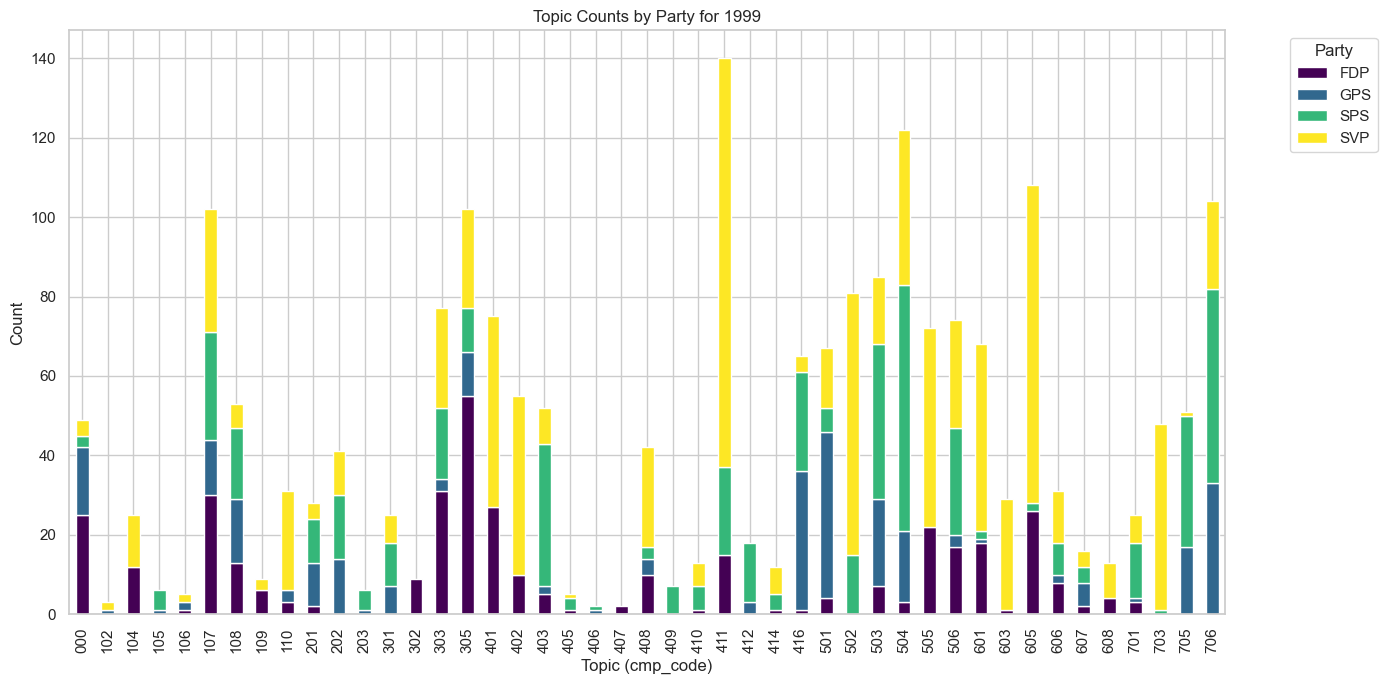

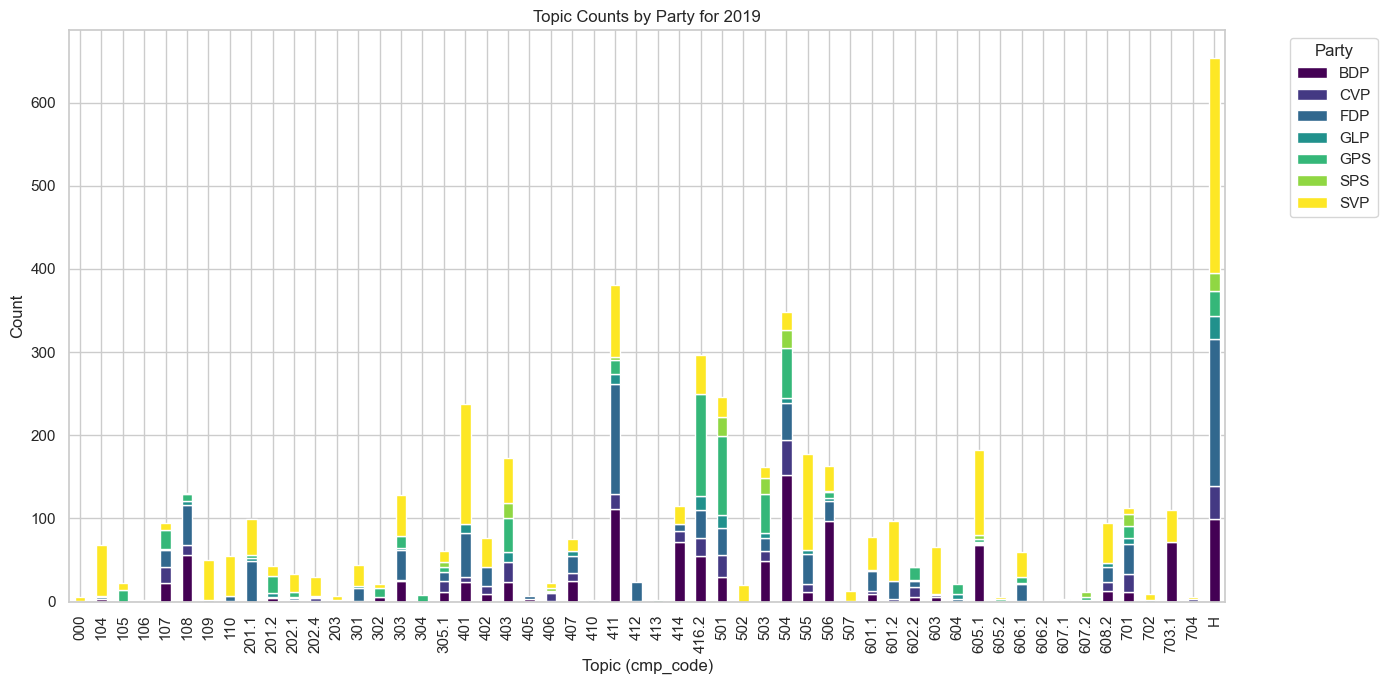

In [15]:
# Filter the dataset for the years 1999 and 2019
filtered_df = df[df['year'].isin([1999, 2019])]
filtered_df = filtered_df.dropna(subset=['cmp_code'])

# Group by year, topic, and party, and count the occurrences
grouped_counts = filtered_df.groupby(['year', 'cmp_code', 'party_name']).size().reset_index(name='count')


# Set the visualization style
sns.set(style="whitegrid")

# Function to plot the count of topics for specific years
def plot_topic_counts(grouped_counts, years):
    for year in years:
        # Filter data for the specific year
        data = grouped_counts[grouped_counts['year'] == year]

        # Pivot the data to create a stacked bar plot
        pivot_data = data.pivot_table(index='cmp_code', columns='party_name', values='count', fill_value=0)

        #  stacked bar chart
        pivot_data.plot(kind='bar', stacked=True, figsize=(14, 7), colormap='viridis')
        plt.title(f'Topic Counts by Party for {year}')
        plt.xlabel('Topic (cmp_code)')
        plt.ylabel('Count')
        plt.legend(title='Party', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()


plot_topic_counts(grouped_counts, years=[1999, 2019])


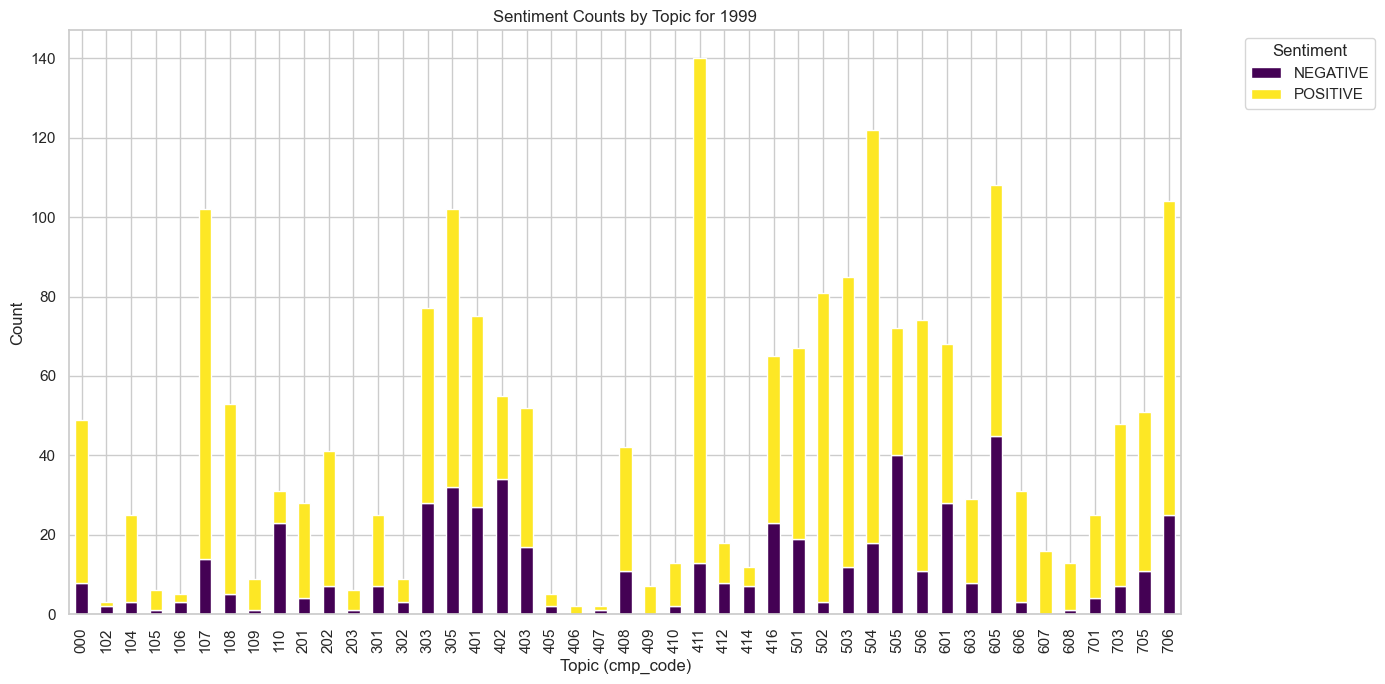

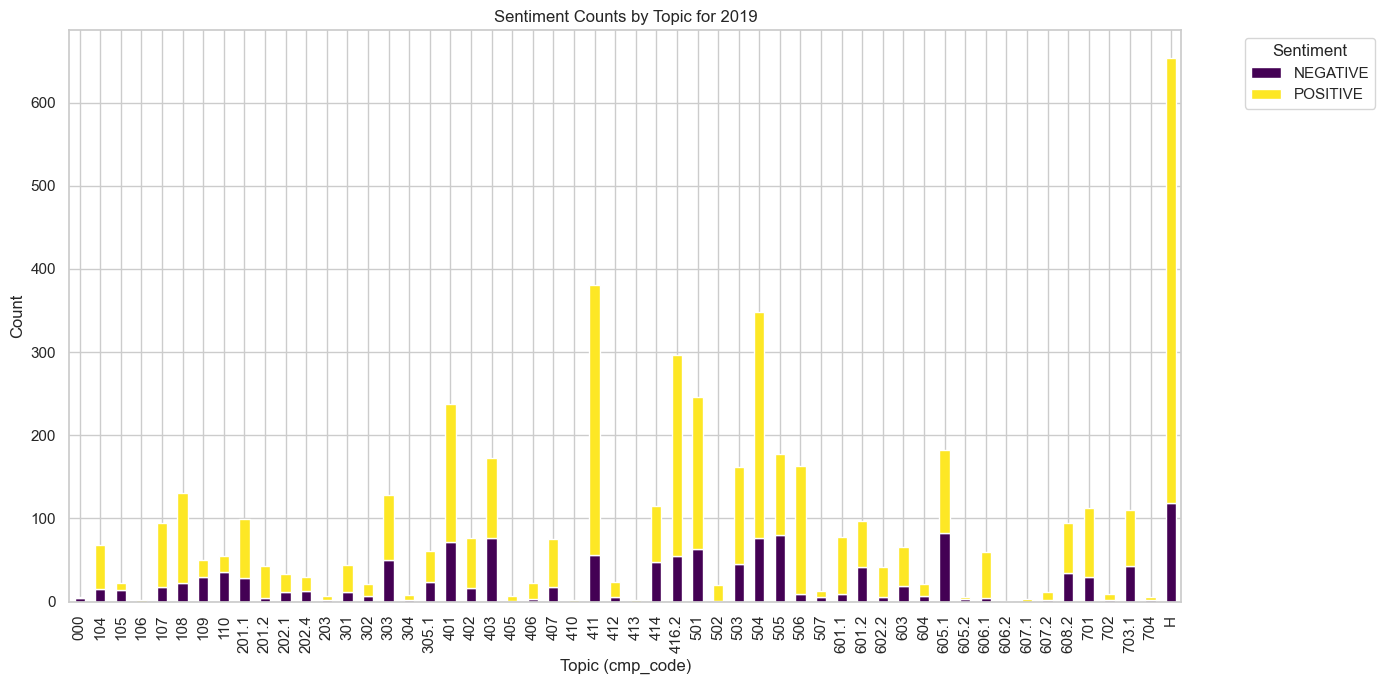

In [16]:
# Filter the dataset for the years 1999 and 2019
filtered_df = df[df['year'].isin([1999, 2019])]
filtered_df = filtered_df.dropna(subset=['cmp_code'])

# Group by year, topic (cmp_code), and sentiment, and count the occurrences
grouped_counts = filtered_df.groupby(['year', 'cmp_code', 'sentiment']).size().reset_index(name='count')


sns.set(style="whitegrid")

# Function to plot the count of topics with sentiment for specific years
def plot_topic_sentiment_counts(grouped_counts, years):
    for year in years:
        # Filter data for the specific year
        data = grouped_counts[grouped_counts['year'] == year]

        # Pivot the data to create a stacked bar plot
        pivot_data = data.pivot_table(index='cmp_code', columns='sentiment', values='count', fill_value=0)

        # Plot the stacked bar chart
        pivot_data.plot(kind='bar', stacked=True, figsize=(14, 7), colormap='viridis')
        plt.title(f'Sentiment Counts by Topic for {year}')
        plt.xlabel('Topic (cmp_code)')
        plt.ylabel('Count')
        plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

# Plot for the years 1999 and 2019
plot_topic_sentiment_counts(grouped_counts, years=[1999, 2019])

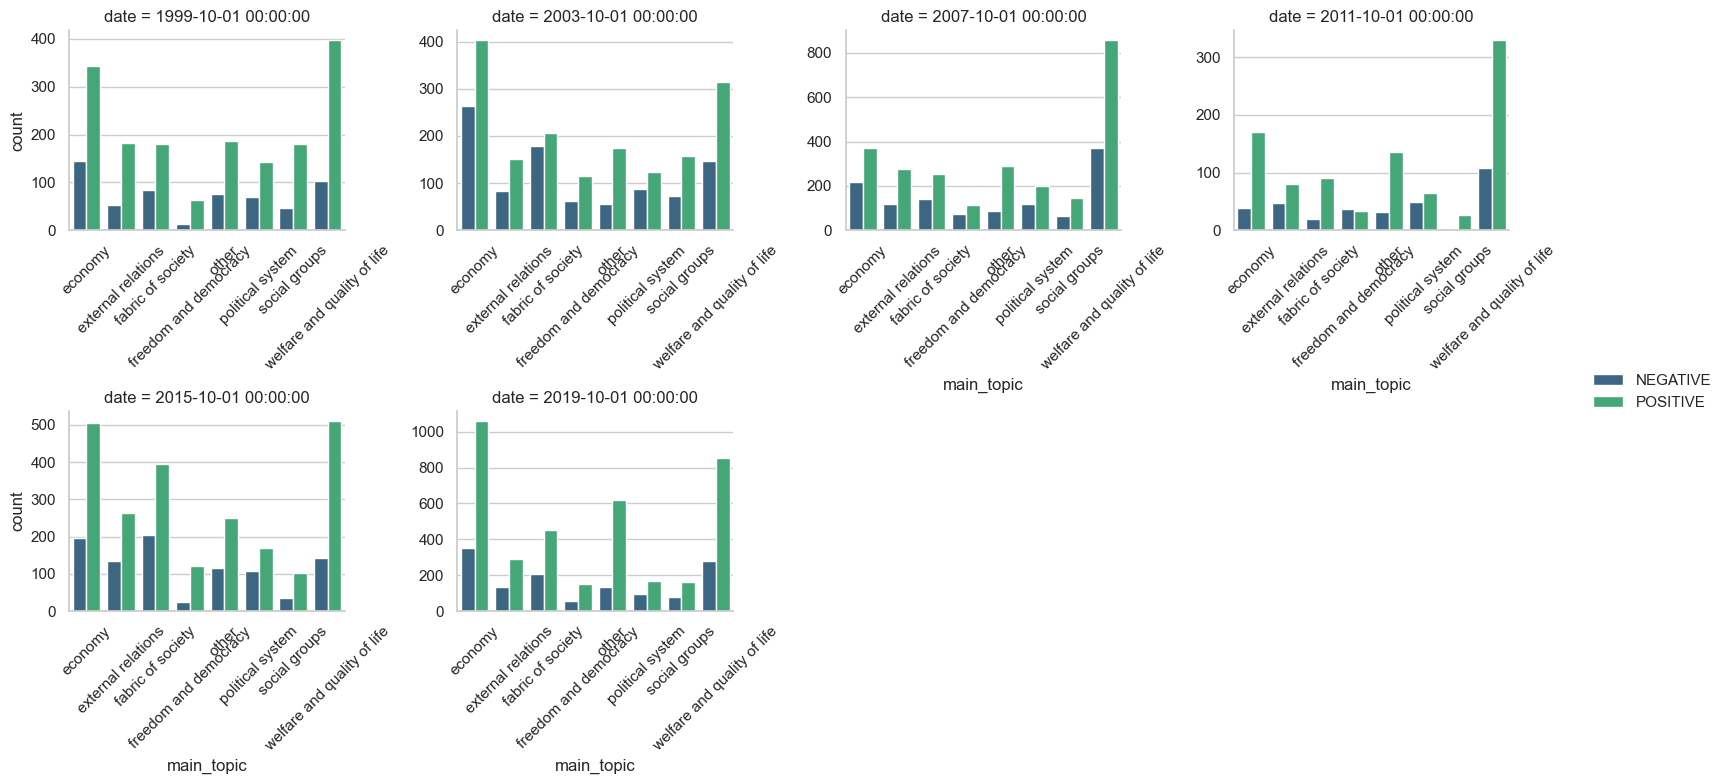

In [17]:
# Group data by 'date', 'main_topic', and 'sentiment' and get the count
grouped_data = df.groupby(['date', 'main_topic', 'sentiment']).size().reset_index(name='count')

g = sns.FacetGrid(grouped_data, col="date", col_wrap=4, height=4, sharex=False, sharey=False)

g.map_dataframe(sns.barplot, x='main_topic', y='count', hue='sentiment', palette='viridis')

g.add_legend()
g.set_xticklabels(rotation=45)
g.tight_layout()


plt.show()

In [18]:
# Function to plot sentiment evolution over time for a given party
def plot_sentiment_evolution(party_name):
    # Filter data for the given party
    data_for_party = df[df['party_name'] == party_name]
    
    # Group by 'date' and 'sentiment' and get the count
    sentiment_over_time = data_for_party.groupby(['date', 'sentiment']).size().reset_index(name='count')
    
    # Pivot the data to get the sentiment counts per date
    sentiment_pivot = sentiment_over_time.pivot(index='date', columns='sentiment', values='count').fillna(0)
    
    # Calculate the percentage of each sentiment
    sentiment_pivot_percent = sentiment_pivot.div(sentiment_pivot.sum(axis=1), axis=0) * 100
    
    # Plot the sentiment evolution over time
    plt.figure(figsize=(12, 6))
    for sentiment in sentiment_pivot_percent.columns:
        plt.plot(sentiment_pivot_percent.index, sentiment_pivot_percent[sentiment], marker='o', label=sentiment)
    
    plt.title(f'Sentiment Evolution Over Time for {party_name}')
    plt.xlabel('Date')
    plt.ylabel('Sentiment Percentage')
    plt.legend(title='Sentiment')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
plot_sentiment_evolution("SVP")
plot_sentiment_evolution("SPS")

In [16]:
# Function to plot sentiment counts over time for each main topic for a given party
def plot_sentiment_by_topic_for_party(party_name):
    # Filter data for the given party
    data_for_party = df[df['party_name'] == party_name]
    
    # Group by 'date', 'main_topic', and 'sentiment' and get the count
    sentiment_by_topic_time = data_for_party.groupby(['date', 'main_topic', 'sentiment']).size().reset_index(name='count')
    
    # Pivot the data to get counts for each main_topic and sentiment per date
    sentiment_pivot = sentiment_by_topic_time.pivot_table(index='date', columns=['main_topic', 'sentiment'], values='count', fill_value=0)
    
    # Plot the sentiment counts over time
    ax = sentiment_pivot.plot(kind='bar', stacked=True, figsize=(14, 8))
    plt.title(f'Sentiment Counts by Main Topic Over Time for {party_name}')
    plt.xlabel('Date')
    plt.ylabel('Sentiment Counts')
    plt.legend(title='Main Topic & Sentiment')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [ ]:
# Sentiment counts by main topic over time for a specific party
plot_sentiment_by_topic_for_party("GPS")
plot_sentiment_by_topic_for_party("SVP")
plot_sentiment_by_topic_for_party("SPS")

In [52]:
# Function to plot the share of negative sentiment by party for a given main topic
def plot_negative_sentiment_share_by_topic(main_topic):
    # Filter the data for the given main topic
    data_for_topic = df[df['main_topic'] == main_topic]
    
    # Drop entries with NaN party names
    data_for_topic = data_for_topic.dropna(subset=['party_name'])

    # Group by 'date', 'party_name', and 'sentiment' to get the counts
    sentiment_counts = data_for_topic.groupby(['date', 'party_name', 'sentiment']).size().reset_index(name='count')
    
    # Pivot to get total sentiment counts per date and party
    total_counts = sentiment_counts.pivot_table(index=['date', 'party_name'], columns='sentiment', values='count', fill_value=0)
    
    # Calculate the share of negative sentiment
    total_counts['negative_share'] = total_counts['NEGATIVE'] / total_counts.sum(axis=1)
    
    # Reset the index for plotting
    total_counts = total_counts.reset_index()
    
    # List of parties to ensure consistent colors
    parties = ['SPS', 'FDP', 'CVP', 'SVP', 'GPS', 'GLP', 'BDP']

    # Color palette for parties
    color_map = {
        'SPS': '#1f77b4',  # Blue
        'FDP': '#ff7f0e',  # Orange
        'CVP': '#2ca02c',  # Green
        'SVP': '#d62728',  # Red
        'GPS': '#9467bd',  # Purple
        'GLP': '#8c564b',  # Brown
        'BDP': '#e377c2'   # Pink
    }

    # Plot the negative sentiment share over time by party
    plt.figure(figsize=(12, 6))
    for party in parties:
        party_data = total_counts[total_counts['party_name'] == party]
        if not party_data.empty:
            plt.plot(party_data['date'], party_data['negative_share'], marker='o', label=party, color=color_map[party])
    
    plt.title(f'Share of Negative Sentiment for {main_topic}: 1999-2019')
    plt.xlabel('Date')
    plt.ylabel('Share of Negative Sentiment')
    plt.legend(title='Party', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

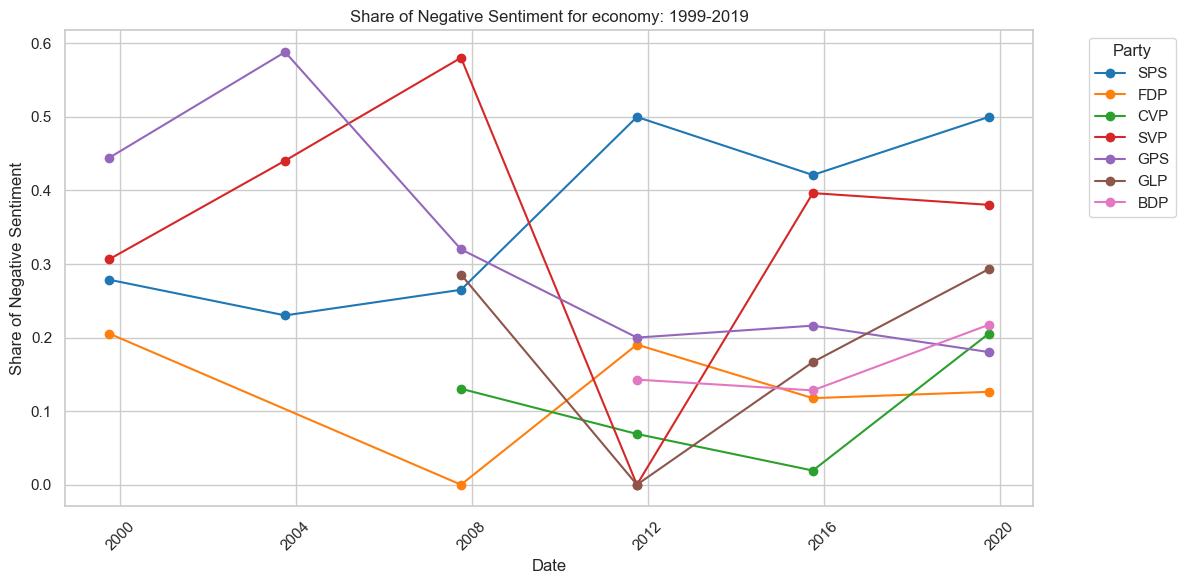

In [53]:
# Share of negative sentiment by party for a specific main topic
plot_negative_sentiment_share_by_topic("economy") 

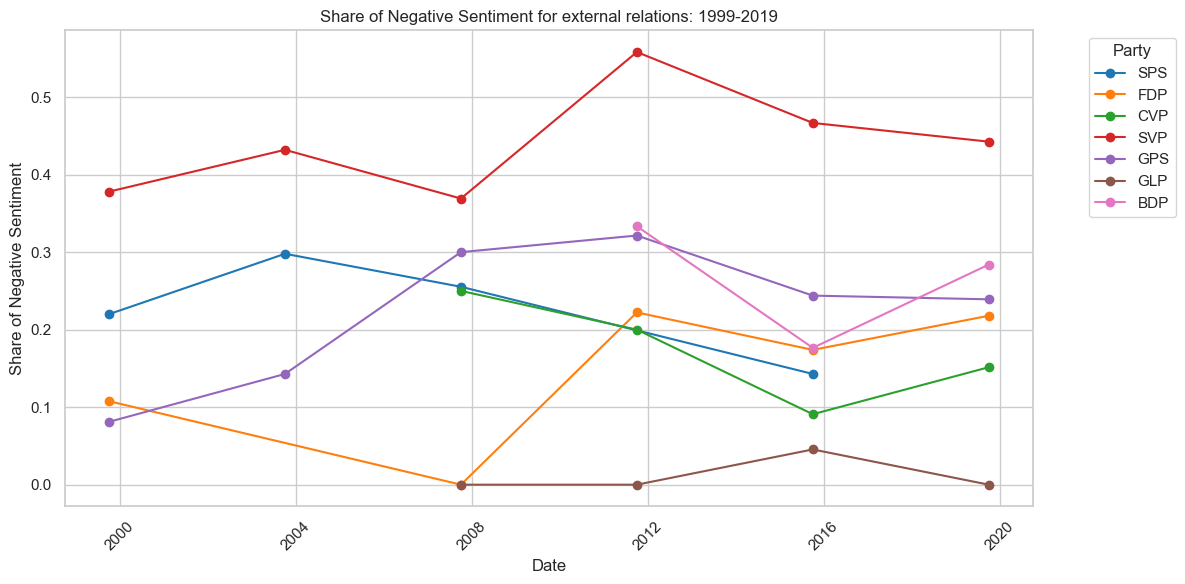

In [54]:
plot_negative_sentiment_share_by_topic("external relations")

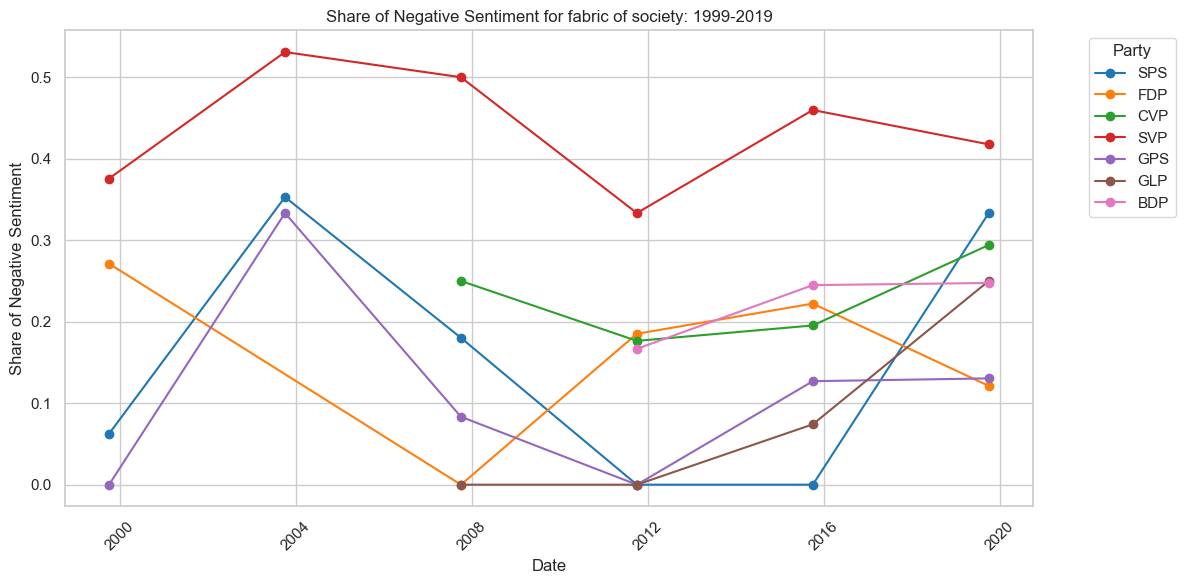

In [55]:
plot_negative_sentiment_share_by_topic("fabric of society")

In [47]:
# Function to plot negative sentiment trends for all parties over time
def plot_negative_sentiment_trends(df):
    # Extract the year from the date column
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year

    # Drop entries with NaN party names
    df = df.dropna(subset=['party_name'])

    # Create a binary column for negative sentiment
    df['is_negative'] = (df['sentiment'] == 'NEGATIVE').astype(int)

    # Group by party and year, calculate share of negative sentiment
    grouped = df.groupby(['party_name', 'year'])['is_negative'].mean().reset_index()

    # Convert to percentage
    grouped['is_negative'] = grouped['is_negative'] * 100

    # List of parties to ensure consistent colors
    parties = ['SPS', 'FDP', 'CVP', 'SVP', 'GPS', 'GLP', 'BDP']

    # Color palette for parties
    color_map = {
        'SPS': '#1f77b4',  # Blue
        'FDP': '#ff7f0e',  # Orange
        'CVP': '#2ca02c',  # Green
        'SVP': '#d62728',  # Red
        'GPS': '#9467bd',  # Purple
        'GLP': '#8c564b',  # Brown
        'BDP': '#e377c2'   # Pink
    }

    # Initialize the plot
    fig, ax = plt.subplots(figsize=(12, 6))

    for party in parties:
        party_data = grouped[grouped['party_name'] == party]
        if not party_data.empty:
            ax.plot(party_data['year'], party_data['is_negative'], label=party, marker='o', color=color_map[party])

    # Customize the plot
    ax.set_title('Share of Negative Sentiment per Year for All Parties: 1999-2019')
    ax.set_xlabel('Year')
    ax.set_ylabel('Negative Sentiment (%)')
    plt.xticks(rotation=45)
    plt.legend(title='Party', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Format y-axis as percentage
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:.1f}%"))

    # Set y-axis
    y_max = grouped['is_negative'].max()
    ax.set_ylim(0, min(y_max * 1.1, 100))  # 10% padding, but not exceeding 100%
    
    # Set x-axis
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))


    plt.tight_layout()
    plt.show()

C:\Users\Laura Mauricio\AppData\Local\Temp\ipykernel_35748\793136994.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_negative'] = (df['sentiment'] == 'NEGATIVE').astype(int)


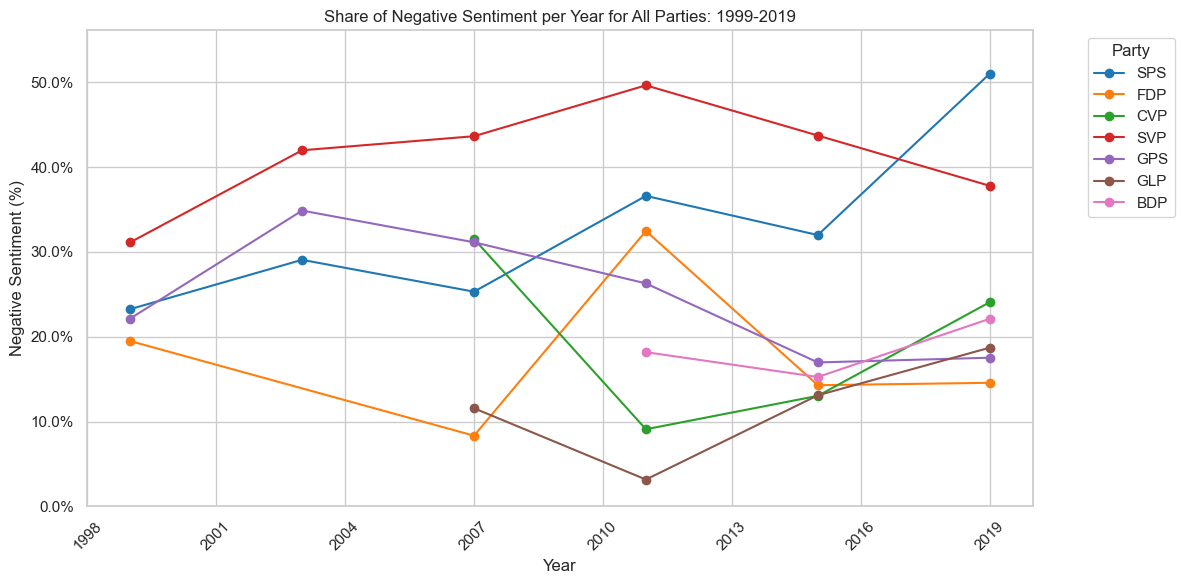

In [48]:
plot_negative_sentiment_trends(df)

In [50]:
# Function to plot negative sentiment overall
def plot_overall_negative_sentiment_trend(df):
    # Create a binary column for negative sentiment
    df['is_negative'] = (df['sentiment'] == 'NEGATIVE').astype(int)

    # Group by year, calculate share of negative sentiment
    grouped = df.groupby('year')['is_negative'].mean().reset_index()

    # Convert to percentage
    grouped['is_negative'] = grouped['is_negative'] * 100

    # Create the plot
    plt.figure(figsize=(12, 6))

    plt.plot(grouped['year'], grouped['is_negative'], marker='o', color='blue', linewidth=2)

    plt.xlabel('Year')
    plt.ylabel('Share of Negative Sentiment (%)')
    plt.title('Evolution of Overall Negative Sentiment Share: 1999-2019')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Format y-axis as percentage
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:.1f}%"))
    
    # Set y-axis limits
    y_max = grouped['is_negative'].max()
    plt.ylim(0, min(y_max * 1.1, 100))  # 10% padding, but not exceeding 100%

    # x-axis 
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))

    plt.tight_layout()
    plt.show()

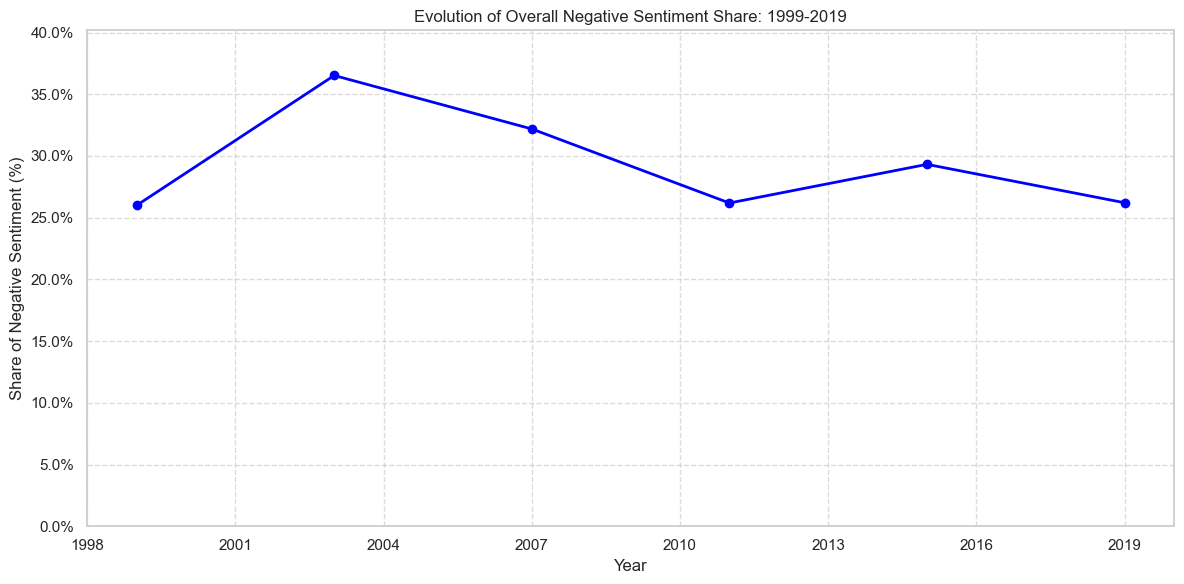

In [51]:
plot_overall_negative_sentiment_trend(df)